# Reconstruction test  
ACAE was trained for 100 epochs 

In [1]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam


from absl import app

# logging
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import shutil
from glob import glob

Using TensorFlow backend.


## Load models

In [2]:
encoder = load_model("/home/aogorodnikov/aae/encoder.h5")
decoder = load_model("/home/aogorodnikov/aae/decoder.h5")
discriminator = load_model("/home/aogorodnikov/aae/discriminator.h5")
generator = load_model("/home/aogorodnikov/aae/generator.h5")

Instructions for updating:
Colocations handled automatically by placer.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## Notes  
We need to set basic parameters for input data, like dimensions, number of filters (3 for RGB)  
Also we compile the models

In [3]:
input_dim = (104,104,3)
latent_dim=32

# compile imported models into assembled autoencoder
autoencoder_input = Input(shape=input_dim)
autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])
discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

## Notes  
We create a function that takes a single class (cellular phenotype) and test reconstruction loss for autoencoder and discriminator

In [4]:
def anomaly_score(cell_pheno draw = true):
    [shutil.rmtree(x) for x in glob("/home/aogorodnikov/test/*")]
    input_dir = os.path.join("/home/aogorodnikov/classes_rgb_corrected/", cell_pheno)
    shutil.copytree(input_dir, os.path.join("/home/aogorodnikov/test/", cell_pheno))
    img_wd = "/home/aogorodnikov/test"
    batch = 56
    input_dim = (104,104,3)
    data_loader = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_data = data_loader.flow_from_directory(
        img_wd,
        target_size=(input_dim[0], input_dim[0]),
        batch_size=batch,
        class_mode='input')
    
    batch_index = 0
    discriminator_batch_losses = []
    while batch_index <= train_data.batch_index:
        data = train_data.next()
        data_list = data[0]
        data_size = len(data_list)

        fake_latent = encoder.predict(data_list)
        discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))
        discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
        discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)

            
        batch_index = batch_index + 1
        discriminator_batch_losses.append(discriminator_history[0])
    
    
    
    
    ae_res = autoencoder.evaluate_generator(train_data)[0]
    adv_res = np.mean(discriminator_batch_losses)
    
    if draw:
        fig = plt.figure(figsize=(5 * len(samples), 5))
        gs = gridspec.GridSpec(1, len(samples))
        for i, sample in enumerate(samples):
            ax = plt.Subplot(fig, gs[i])
            ax.imshow((sample["image"] * 255.).astype("int"), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            ax.set_title(sample["title"])
            fig.add_subplot(ax)
        plt.show(block=False)
        
    
    print('Class: {}\nae_loss: {}\nadv_loss: {}'.format(cell_pheno, ae_res, adv_res))
    return [ae_res, adv_res]
    
        

## Notes  
We create a list of thise class directories and deploy the function above in list comprehension logic

In [5]:
dirs = [x for x in os.listdir("/home/aogorodnikov/classes_rgb_corrected/") if os.path.isdir(os.path.join("/home/aogorodnikov/classes_rgb_corrected/", x))]
results = [[x, anomaly_score(cell_pheno=x)] for x in dirs]

Found 684 images belonging to 1 classes.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


24/24 [==============================] - 0s 185us/step
Class: confluent
ae_loss: 0.003990047197375033
adv_loss: 0.7823838467126364
Found 313 images belonging to 1 classes.
66/66 [==============================] - 0s 290us/step
Class: cytokinesis
ae_loss: 0.00479467329197227
adv_loss: 0.8040526820209637
Found 1124 images belonging to 1 classes.
8/8 [==============================] - 0s 366us/step
Class: negative
ae_loss: 0.002872665228779524
adv_loss: 0.7411487153192767
Found 310 images belonging to 1 classes.
60/60 [==============================] - 0s 262us/step
Class: nuclear_mess
ae_loss: 0.004974675755346975
adv_loss: 0.8267828428556049
Found 857 images belonging to 1 classes.
34/34 [==============================] - 0s 329us/step
Class: large_nuclei
ae_loss: 0.0037249213012854722
adv_loss: 0.8074777071215525
Found 1077 images belonging to 1 classes.
26/26 [==============================] - 0s 179us/step
Class: other
ae_loss: 0.0028704403019306998
adv_loss: 0.7546617584569113
Found

## Notes  
Printed results show adversarial and autoencoder losses fpr each class

In [6]:
results

[['confluent', [0.003990047197375033, 0.7823838467126364]],
 ['cytokinesis', [0.00479467329197227, 0.8040526820209637]],
 ['negative', [0.002872665228779524, 0.7411487153192767]],
 ['nuclear_mess', [0.004974675755346975, 0.8267828428556049]],
 ['large_nuclei', [0.0037249213012854722, 0.8074777071215525]],
 ['other', [0.0028704403019306998, 0.7546617584569113]],
 ['micronuclei', [0.004338426713170952, 0.8185977354120456]],
 ['spindle', [0.00319564609858049, 0.7359470431517838]],
 ['Y', [0.004104753278873183, 0.7166841346876962]],
 ['binucleated', [0.003716825449373573, 0.8022964660610472]],
 ['polarity', [0.003804593114182353, 0.7368772821766989]],
 ['croissant', [0.003620269022948383, 0.7348328779777283]]]

In [24]:
rec_loss = [x[1][0] for x in results]
adv_loss = [x[1][1] for x in results]

In [37]:
min(adv_loss)

0.7166841346876962

In [35]:
np.percentile(adv_loss, 60)

0.7943314183216829

# Conclusions  
1. *Negative* class has the smallest autoencoder and a small adversarial loss.  
2. An anomaly will be determined by the logic `if {dv_loss OR rec_loss} > 60'th percentile` 

In [38]:
img_wd = "/home/aogorodnikov/classes_rgb_corrected/"
batch = 56
input_dim = (104,104,3)
latent_dim=32
epoch = 10
conv=True
adversarial=True


In [39]:
# LOAD DATA
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')

Found 7557 images belonging to 12 classes.


In [40]:
data = train_data.next()
data_list = data[0]
fake_latent = encoder.predict(data_list)

In [41]:
def draw(samples):
    fig = plt.figure(figsize=(5 * len(samples), 5))
    gs = gridspec.GridSpec(1, len(samples))
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).astype("int"), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)

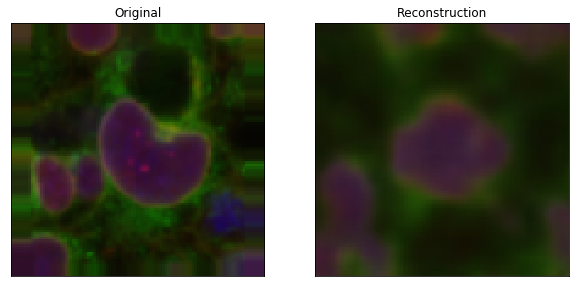

In [45]:
choice = np.random.choice(np.arange(32))
original = data_list[choice]

original_1 = np.expand_dims(original, axis=0)

latent = encoder.predict(original_1)

reconstruction = decoder.predict(latent)

draw([{"title": "Original", "image": original}, {"title": "Reconstruction", "image": reconstruction[0]}])

